Code taken from source below and customised

https://github.com/aladdinpersson/Machine-Learning-Collection/tree/master/ML/Pytorch/pytorch_lightning/6.%20Restructuring

## Libraries

In [57]:
import torch
import torch.nn.functional as F
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch import nn, optim
from torch.utils.data import DataLoader
from tqdm import tqdm                       # Progress bar
from torch.utils.data import random_split
import torchmetrics
from torchmetrics import Metric

import lightning as L                       # PyTorch Lightning

import matplotlib.pyplot as plt
import numpy as np

## Configuration

In [2]:
# Training hyperparameters
INPUT_SIZE = 784
NUM_CLASSES = 10
LEARNING_RATE = 0.001
BATCH_SIZE = 64
NUM_EPOCHS = 10

# Dataset
DATA_DIR = "dataset/"
NUM_WORKERS = 4

# Compute related
ACCELERATOR = "cpu"
DEVICES = 1
PRECISION = 16

## Dataset
Using the LightningDataModule

https://lightning.ai/docs/pytorch/stable/data/datamodule.html

MNIST Dataset loaded from:

https://pytorch.org/vision/stable/datasets.html

In [44]:
class MnistDataModule(L.LightningDataModule):
    def __init__(self, data_dir, batch_size, num_workers):
        super().__init__()
        self.data_dir = data_dir
        self.batch_size = batch_size
        self.num_workers = num_workers

    def prepare_data(self):
        datasets.MNIST(self.data_dir, train=True, download=True)
        datasets.MNIST(self.data_dir, train=False, download=True)

    def setup(self, stage):
        entire_dataset = datasets.MNIST(
            root=self.data_dir,
            train=True,
            transform=transforms.ToTensor(),
            download=False,
        )
        self.train_ds, self.val_ds = random_split(entire_dataset, [50000, 10000])
        self.test_ds = datasets.MNIST(
            root=self.data_dir,
            train=False,
            transform=transforms.ToTensor(),
            download=False,
        )
        # Create a small dataset for prediction, which is a subset of the test dataset
        _, self.pred_ds = random_split(self.test_ds, [9900, 100])

    def train_dataloader(self):
        return DataLoader(
            self.train_ds,
            batch_size=self.batch_size,
            num_workers=self.num_workers,
            shuffle=True,
            persistent_workers=True,        # Considered to speed up the dataloader worker initialization
        )

    def val_dataloader(self):
        return DataLoader(
            self.val_ds,
            batch_size=self.batch_size,
            num_workers=self.num_workers,
            shuffle=False,
            persistent_workers=True,        # Considered to speed up the dataloader worker initialization
        )

    def test_dataloader(self):
        return DataLoader(
            self.test_ds,
            batch_size=self.batch_size,
            num_workers=self.num_workers,
            shuffle=False,
            persistent_workers=True,        # Considered to speed up the dataloader worker initialization
        )
    
    def predict_dataloader(self):
        return DataLoader(
            self.pred_ds,
            batch_size=100,                 # set the batch size to 100 for prediction
            num_workers=self.num_workers,
            shuffle=False,
            persistent_workers=True,        # Considered to speed up the dataloader worker initialization
        )


## Model
Using the LightningModule

https://lightning.ai/docs/pytorch/stable/common/lightning_module.html

####  FCM - Fully connected model

In [21]:
class FCM(L.LightningModule):
    def __init__(self, input_size, learning_rate, num_classes):
        super().__init__()
        self.lr = learning_rate

        # Architecture
        self.fc1 = nn.Linear(input_size, 20)
        self.fc2 = nn.Linear(20, num_classes)
        
        # Loss function and metrics
        self.loss_fn = nn.CrossEntropyLoss()
        self.accuracy = torchmetrics.Accuracy(task="multiclass", num_classes=num_classes)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x
    
    # Common step for training, validation, and test steps, to avoid code duplication
    def _common_step(self, batch, batch_idx):
        x, y = batch
        x = x.reshape(x.size(0), -1)
        scores = self.forward(x)
        loss = self.loss_fn(scores, y)
        return loss, scores, y

    def training_step(self, batch, batch_idx):
        loss, scores, y = self._common_step(batch, batch_idx)
        accuracy = self.accuracy(scores, y)
        self.log_dict({"train_loss": loss,"train_acc": accuracy},
                      on_step=False,
                      on_epoch=True,
                      prog_bar=True,
                      )
        return {"loss": loss, "scores": scores, "y": y}

    def validation_step(self, batch, batch_idx):
        loss, scores, y = self._common_step(batch, batch_idx)
        self.log("val_loss", loss)
        return loss

    def test_step(self, batch, batch_idx):
        loss, scores, y = self._common_step(batch, batch_idx)
        self.log("test_loss", loss)
        return loss

    def predict_step(self, batch, batch_idx):
        x, y = batch
        x = x.reshape(x.size(0), -1)
        scores = self.forward(x)
        # preds = torch.argmax(scores, dim=1)
        return scores                                 # Return the scores for further processing

    def configure_optimizers(self):
        return optim.Adam(self.parameters(), lr=self.lr)

#### CNN - Convolutional neural network

In [5]:
class CNN(L.LightningModule):
    def __init__(self, input_size, learning_rate, num_classes):
        super().__init__()
        self.lr = learning_rate
        # input_size is not used in this model, only for consistency

        # Architecture
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.fc1 = nn.Linear(64 * 7 * 7, 128)
        self.fc2 = nn.Linear(128, num_classes)
        
        # Loss function and metrics
        self.loss_fn = nn.CrossEntropyLoss()
        self.accuracy = torchmetrics.Accuracy(task="multiclass", num_classes=num_classes)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2, 2)
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x
    
    # Common step for training, validation, and test steps, to avoid code duplication
    def _common_step(self, batch, batch_idx):
        x, y = batch
        scores = self.forward(x)
        loss = self.loss_fn(scores, y)
        return loss, scores, y

    def training_step(self, batch, batch_idx):
        loss, scores, y = self._common_step(batch, batch_idx)
        accuracy = self.accuracy(scores, y)
        self.log_dict({"train_loss": loss,"train_acc": accuracy},
                      on_step=False,
                      on_epoch=True,
                      prog_bar=True,
                      )
        return {"loss": loss, "scores": scores, "y": y}

    def validation_step(self, batch, batch_idx):
        loss, scores, y = self._common_step(batch, batch_idx)
        self.log("val_loss", loss)
        return loss

    def test_step(self, batch, batch_idx):
        loss, scores, y = self._common_step(batch, batch_idx)
        self.log("test_loss", loss)
        return loss
    
    def predict_step(self, batch, batch_idx):
        x, y = batch
        x = x.reshape(x.size(0), -1)
        scores = self.forward(x)
        # preds = torch.argmax(scores, dim=1)
        return scores                                 # Return the scores for further processing

    def configure_optimizers(self):
        return optim.Adam(self.parameters(), lr=self.lr)

## Training
Using the Trainer

https://lightning.ai/docs/pytorch/stable/common/trainer.html

In [22]:
model = FCM(input_size=INPUT_SIZE,
            learning_rate=LEARNING_RATE,
            num_classes=NUM_CLASSES,
            )

In [23]:
dm = MnistDataModule(data_dir=DATA_DIR,
                     batch_size=BATCH_SIZE,
                     num_workers=NUM_WORKERS,
                     )

In [24]:
trainer = L.Trainer(# accelerator=ACCELERATOR,
                    # devices=DEVICES,
                    max_epochs=NUM_EPOCHS,
                    # precision=PRECISION,
                    # profiler="simple",      # profiler to check for bottlenecks
                    )

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [25]:
trainer.fit(model, dm)


  | Name     | Type               | Params
------------------------------------------------
0 | fc1      | Linear             | 15.7 K
1 | fc2      | Linear             | 210   
2 | loss_fn  | CrossEntropyLoss   | 0     
3 | accuracy | MulticlassAccuracy | 0     
------------------------------------------------
15.9 K    Trainable params
0         Non-trainable params
15.9 K    Total params
0.064     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


In [10]:
trainer.validate(model, dm)

Validation: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         val_loss          │    0.14089079201221466    │
└───────────────────────────┴───────────────────────────┘

[{'val_loss': 0.14089079201221466}]

In [11]:
trainer.test(model, dm)

Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │    0.16112245619297028    │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 0.16112245619297028}]

## Make predictions

In [46]:
pred = trainer.predict(model, dm)

Predicting: |          | 0/? [00:00<?, ?it/s]

In [50]:
# Create a tensor from the prediction list
predictions = pred[0]

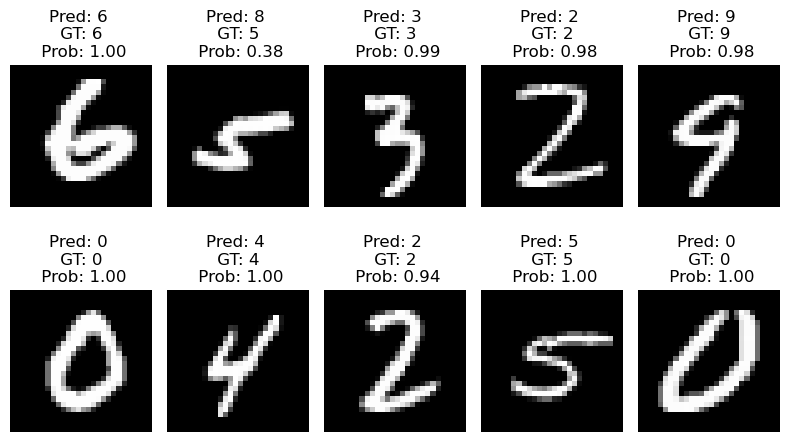

In [74]:
# Plot the first 10 images and their predictions and ground truth
# Show also the softmax probability of the prediction

fig, axs = plt.subplots(2, 5, figsize=(8, 5))
for i in range(10):
    ax = axs[i // 5, i % 5]
    ax.imshow(dm.pred_ds[i][0].squeeze(), cmap="gray")
    ax.set_title(f"Pred: {np.argmax(predictions[i])} \n GT: {dm.pred_ds[i][1]} \n Prob: {torch.max(F.softmax(predictions[i], dim=0)):.2f}")
    ax.axis("off")
plt.tight_layout()
plt.show()